## METHODOLOGY

#### Supervised Part:

> 1. Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.    
     
> 2. Strip last 3 Dense Layers.   
    
> 3. Do a forward pass with `X_train` and `X_test` on `model_bottom`. Save outputs as `X_train_features` and `X_test_features`.

> 4. Reserve the first half of `(X_test_features, y_test)` for `(X_cv_features, y_cv)`.

> 5. Create a new model that accepts VGG16 bottleneck features as input. Call this `model_top`.

> 6. Train `model_top` on `X_train_features` with validation on `(X_cv_features, y_cv)`.

> 7.  Load best performing model weights and compute accuracy on `(X_test_features, y_test)`.

#### Now the Unsupervised Part:

> 8. Compute `y_unlabeled_predict` via forward pass with `X_unlabeled` on `model_top`.

> 9.  If max probability of `y_unlabeled_predict` exceeds `threshold = 0.9` on any class, append that example to an additional training data `X_train_add` with the class `y_train_add`.

> 10. Compute `X_train_add_features` via forward pass with `X_train_add` on `model_bottom`.

> 11. Concatenate `X_train_features` and `X_train_add_features` into `X_train_2_features`. Concatenate `y_train` and `y_train_add` into `y_train_2`.

> 12. Re-train `model_top` on `X_train_2_features` and `y_train_2` (N.B. use the STL-10 trained weights as initial weights). For cross-validation use same dataset `(X_cv_features, y_cv)`.

> 13. Load best performing model weights and compute accuracy on `(X_test_features, y_test)`.




In [27]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4236006328499133139
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 342622208
locality {
  bus_id: 1
}
incarnation: 9395491599803596506
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
from stl10_input import *
import os, sys, tarfile, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

params = {'legend.fontsize': 'x-large',
          'font.size'      : 10,
          'figure.figsize' : (17, 3),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)

DATA_PATH = './data/train_X.bin'
LABEL_PATH = './data/train_y.bin'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

# Supervised Part

### Read in training and test STL-10 datasets

In [12]:
with open('data/train_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_train_raw = raw
    
with open('data/train_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_train = raw - 1 # class labels are originally in 1-10 format. Convert them to 0-9 format

with open('data/test_X.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    raw = np.reshape(raw, (-1, 3, 96, 96))
    raw = np.transpose(raw, (0,3,2,1))
    X_test_raw = raw

with open('data/test_y.bin') as f:
    raw = np.fromfile(f, dtype=np.uint8, count=-1)
    y_test = raw - 1 
    
#---------------------------------------------------------
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 1000)
y_test  = to_categorical(y_test , num_classes = 1000)

cnames, fidx = get_cnames_fidx(y_train, n_split=5)
print('All labeled data loaded.')

Class names retrieved in cnames
K-Fold indices generated, n_split = 5
Fold width = 1000
Number of data points for each class = 200
All labeled data loaded.


### Resize the original `(96,96,3)` images to `(224,224,3)` 


In [13]:
# takes ~20 sec to run.
start = time.time()
from PIL import Image

def resize_tensorimages(X_raw, interp_method=Image.BICUBIC):
    # VGG16 accepts input images of size (224, 224, 3)
    # Therefore, convert X_train_raw and X_test_raw to PIL.Image format, 
    # then resize the images from (96, 96, 3) to (224, 224, 3) 
    
    X_224 = np.zeros((X_raw.shape[0], 224, 224, 3))
    for i, _ in enumerate(X_raw):
        im = Image.fromarray(np.uint8(X_raw[i]))
        img = im.resize((224, 224), interp_method)
        X_224[i] = img
    
    return X_224

X_train = resize_tensorimages(X_train_raw)
X_test  = resize_tensorimages(X_test_raw)
    
del X_train_raw, X_test_raw
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print_runtime(start)

(5000, 224, 224, 3) (5000, 1000)
(8000, 224, 224, 3) (8000, 1000)
Runtime: 0 min 21 sec


---

# Obtain Bottleneck Features for VGG16
### 1.  Load VGG16 model weights pre-trained on Imagenet. Call it `model_bottom`.     


### 2.  Strip last 3 Dense Layers.   

In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#---------------------------------------------------------

model_bottom = VGG16(include_top=False)

### 3. Do a forward pass with `X_train` and `X_test` on `model_bottom`.   Save outputs as `X_train_features` and `X_test_features`.

In [15]:
start = time.time()
#---------------------------------------------------------

# batch_size = 128

# X_train = preprocess_input(X_train) 
# X_test = preprocess_input(X_test) 
# d = model.predict(X_train[0:2])

# X_train_features = np.zeros((X_train.shape[0],*d.shape[1:]))

# for i in range(len(X_train)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Training set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_train_features[idx] = model.predict(X_train[idx])    
# X_train_features[(i+1)*batch_size:] = model.predict(X_train[(i+1)*batch_size:])

# #---------------------------------------------------------
# print() 
# # Save `X_train_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_train_features.npy', 'wb+') as f:
#     np.save(f, X_train_features)


### Load `X_train_features` from `.npy` file. 
with open('data/X_train_features.npy','rb') as f:
    X_train_features = np.load(f)     
#---------------------------------------------------------

### Compute `X_test_features` on pretrained `VGG16` model.
# X_test_features  = np.zeros((X_test.shape[0], *d.shape[1:]))
# for i in range(len(X_test)//batch_size):
#     idx = range(i*batch_size, (i+1)*batch_size)
#     print('Test set: %5.2f%%' % ((i+1)/(len(X_train)//batch_size)*100), end='\r')
#     X_test_features[idx] = model.predict(X_test[idx])
# X_test_features[(i+1)*batch_size:] = model.predict(X_test[(i+1)*batch_size:])

# print()
# # Save `X_test_features` to `.npy` file, so you don't have to run this again.
# with open('data/X_test_features.npy', 'wb+') as f:
#     np.save(f, X_test_features)


### Load `X_test_features` from `.npy` file.
with open('data/X_test_features.npy','rb') as f:
    X_test_features = np.load(f)
    
#---------------------------------------------------------
print_runtime(start)

Runtime: 0 min 12 sec


#### Try mixing original trainingin and test sets and re-splitting the data into 5000 for the training and 8000 for the test set.

In [16]:
idx = list(range(13000))
np.random.shuffle(idx)
X_all = np.concatenate([X_train_features, X_test_features])
y_all = np.concatenate([y_train, y_test])

X_train_features = X_all[idx[:5000]]
y_train = y_all[idx[:5000]]
X_test_features = X_all[idx[5000:]]
y_test = y_all[idx[5000:]]

del X_all, y_all

### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.

### 6. Perform k-fold with `k=10` cross validation on `model_top`.

### 7.  Print average Test Accuracy.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_52  (None, 512)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 1000)              513000    
_________________________________________________________________
dense_98 (Dense)             (None, 1000)              1001000   
Total params: 1,514,000
Trainable params: 1,514,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.16423, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.16423 to 0.15167, saving model to saved_models/mo

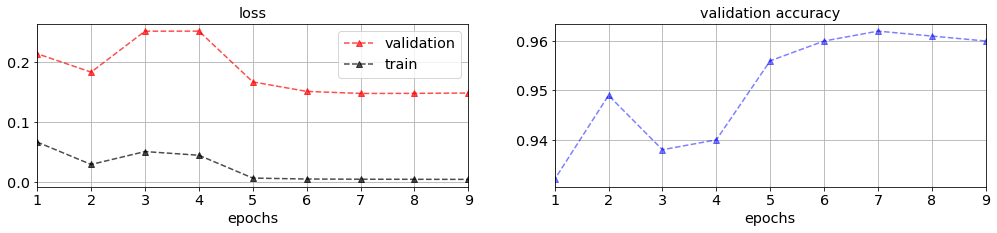

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.29771, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.29771 to 0.22393, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.22393 to 0.20573, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.20573 to 0.17235, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Runtime: 0 min 20 sec
7808/8000 [============================>.] - ETA: 0s
k = 1
Test Accuracy = 94.46 %


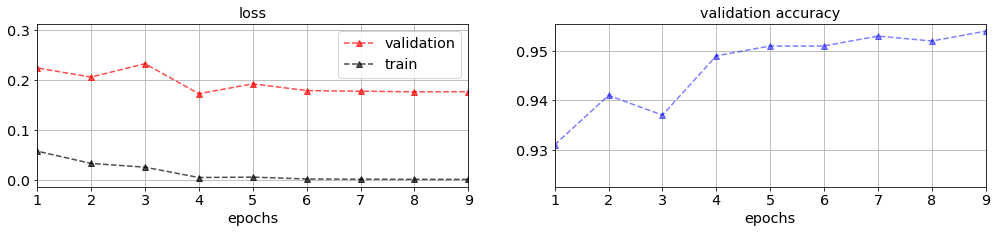

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.28182, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.28182 to 0.19158, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.19158 to 0.18609, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.18609 to 0.17621, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Runtime: 0 min 19 sec
8000/8000 [==============================] - 0s     

k = 2
Test Accuracy = 94.91 %


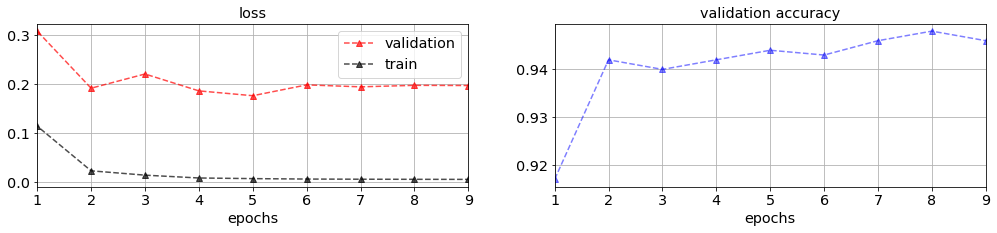

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.32566, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.32566 to 0.24550, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Runtime: 0 min 19 sec
7808/8000 [============================>.] - ETA: 0s
k = 3
Test Accuracy = 94.44 %


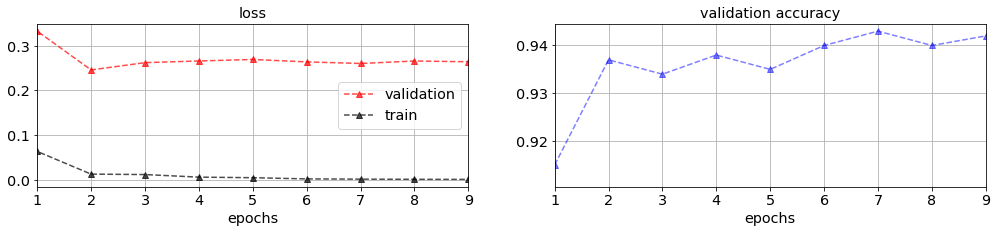

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.28282, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.28282 to 0.23186, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.23186 to 0.19026, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.19026 to 0.16969, saving model to saved_models/model.best.hdf5
Epoch 00005: val_loss improved from 0.16969 to 0.15398, saving model to saved_models/model.best.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.15398 to 0.15165, saving model to saved_models/model.best.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Runtime: 0 min 19 sec
7808/8000 [============================>.] - ETA: 0s
k = 4
Test Accuracy = 94.67 %


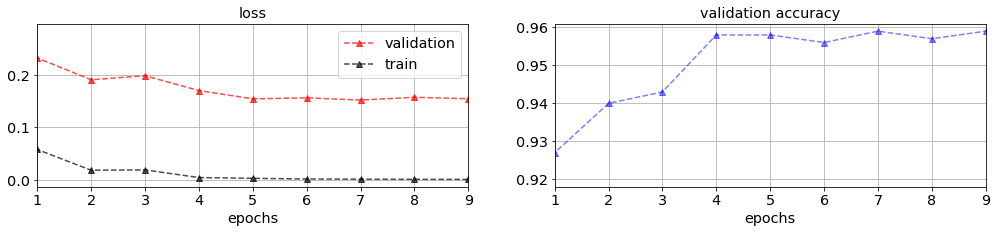



------------------------------
------------------------------
------------------------------
k = 5
K-Fold Average Test Accuracy = 94.62 %  <==
Runtime: 1 min 50 sec


In [38]:
start = time.time()
acc = []

### Do a k-fold
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, shuffle=True)
# for fidx_train, fidx_cv in kf.split(y_train):
for k, _ in enumerate(fidx):
    fidx_cv = fidx[k]
    fidx_train = np.concatenate([fidx[0:k],fidx[k+1:]]).flatten()
    
    X_cv_features_1k = X_train_features[fidx_cv]
    y_cv_1k = y_train[fidx_cv]
    
    X_train_features_9k = X_train_features[fidx_train]
    y_train_9k = y_train[fidx_train]
    
    
    ### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.
    model_top = construct_model()
    if k == 0: model_top.summary()
    ### 6. Train `model_top` on  `X_train_features` with validation on `(X_cv_features, y_cv)`.
    model_top, callback_inst = train_model(model_top, 
                                           X_train_features_9k, y_train_9k,
                                           X_cv_features_1k, y_cv_1k, 
                                           epochs=10,
                                           batch_size=64,
                                           wanna_plot=False)
    ### 7.  Compute test accuracy.
    model_top.load_weights('saved_models/model.best.hdf5')

    _loss, _acc = model_top.evaluate(X_test_features, y_test, 
                                    batch_size=128);
    acc.append(_acc)
    print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

    ### Plot loss function and accuracy
    callback_inst.plotter()

print(('\n' + ('\n'+'-'*30)*2 +'\nIn %i Folds'+ '\nK-Fold Average Test Accuracy = %.2f %%  <==') % 
      (len(fidx), np.mean(acc)*100))
print_runtime(start)


---

# Unsupervised Part
### Load unlabeled STL-10 data into `X_unlabeled_raw`.

In [241]:
## 2.8 GB !!! 
# The (224, 224, 3) tensor will not fit in memory.
# Build a generator
# with open('data/unlabeled_X.bin') as f:
#     raw = np.fromfile(f, dtype=np.uint8, count=-1)
#     raw = np.reshape(raw, (-1, 3, 96, 96))
#     raw = np.transpose(raw, (0,3,2,1))
#     X_unlabeled_raw = raw

# print(X_unlabeled_raw.shape)  
# print('X_unlabeled_raw.nbytes = %.2f MB' % (X_unlabeled_raw.nbytes/1e6)  )

### 8. Resize original `(96,96,3)` images to `(224,224,3)`––call them `X_unlabeled_224`.
### 9.  Compute `X_unlabeled_features ` via forward pass on `model_bottom`.
### 10.  Compute `y_unlabeled_predict` via forward pass of `X_unlabeled_features` on `model_top`.  
### 11. Save `X_unlabeled_features` and `y_unlabeled_predict` to corresponding `.npy` files.


In [242]:
# # NPY FILE MAKER

# start = time.time()

# # .....................................................................

# batch_size = 128
# sno = -1
# n_batches = len(X_unlabeled_raw)//batch_size

# X_unlabeled_raw = X_unlabeled_raw.astype('float32')
# X_unlabeled_features_repo = np.array([])

# for i in range(0, n_batches):
#     idx = range(i*batch_size, min((i+1)*batch_size, len(X_unlabeled_raw)))

#     # Resize raw image tensors.
#     X_unlabeled_224 = resize_tensorimages(X_unlabeled_raw[idx])
    
#     # Forward pass X_unlabeled_224 on model_bottom.
#     # (This is the time-consuming step.)
#     # X_unlabeled_features.shape = (128, 7, 7, 512)
#     X_unlabeled_features = model_bottom.predict(X_unlabeled_224, batch_size=batch_size) 
    
#     # Retrieve softmax probabilities on all classes.
#     # y_unlabeled_softmax.shape = (128, 1000)
#     y_unlabeled_softmax = model_top.predict(X_unlabeled_features) 
    
#     diff = time.time()-start
#     print('i = %d, n_batches = %d, Time: %d min %d sec  ' % (i, n_batches, diff//60, diff%60), end='\r')
    
#     if len(X_unlabeled_features_repo.shape) == 1:
#         X_unlabeled_features_repo = X_unlabeled_features
#         y_unlabeled_softmax_repo  = y_unlabeled_softmax
#     else:
#         X_unlabeled_features_repo = np.concatenate([X_unlabeled_features_repo, X_unlabeled_features])
#         y_unlabeled_softmax_repo  = np.concatenate([y_unlabeled_softmax_repo , y_unlabeled_softmax])
    
#     if X_unlabeled_features_repo.nbytes > 250*1e6:
#         sno = sno + 1
#         print()
#         npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#         npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)
#         print('---------------------------------------------------------')
#         X_unlabeled_features_repo = np.array([])

# if len(X_unlabeled_features_repo) > 1:
#     sno = sno + 1
#     print()
#     npy_saver(X_unlabeled_features_repo, 'X_unlabeled_features', sno)
#     npy_saver(y_unlabeled_softmax_repo , 'y_unlabeled_softmax' , sno)

# del X_unlabeled_features_repo, y_unlabeled_softmax_repo, X_unlabeled_224
# print_runtime(start)
# print('\nDone!!')

### 11.  If max probability of `y_unlabeled_predict` exceeds `threshold = 0.9` on any class, append that example to an additional training data `X_train_add` with the class `y_train_add`.
##### Each `X_unlabeled_features_**.npy` is of length `2560` and size `257 MB`.

In [56]:
start = time.time()

threshold = .80
outX = []
outy = []

X_train_add_features = np.array([]) 
import glob
npys = glob.glob('data/*_softmax_*npy')
npys.sort(reverse=True)
highest_sno = int(npys[0].split('.npy')[0].split('_')[-1])

print('threshold = %.2f' % (threshold))
for sno in range(0, highest_sno):
    with open('data/%s_%02d.npy' % ('X_unlabeled_features', sno), 'rb') as fX,\
        open('data/%s_%02d.npy' % ('y_unlabeled_softmax', sno), 'rb') as fy:
        
        print('Reading in:', fX.name, ', ', fy.name , end='\r')
        X_unlabeled_features = np.load(fX) # shape (2560, 7, 7, 512)
        y_unlabeled_softmax  = np.load(fy) # (2560, 1000)

    # Find index of predicted class.
    # topclass_idx.shape = (2560,)
    topclass_idx = np.argmax(y_unlabeled_softmax, axis=1) 
    
    # prob: probability associated with topclass. shape = (2560,)
    prob = y_unlabeled_softmax[ range(y_unlabeled_softmax.shape[0]) , topclass_idx ]
    predict_idx = np.where(prob > threshold)[0]
    
    outX.append(X_unlabeled_features[predict_idx] )
    onehot = np.zeros((len(predict_idx) , 1000))
    onehot[range(len(predict_idx)), topclass_idx[predict_idx] ] = 1
    outy.append(onehot)
    
# ................................................................    
# with open('data/X_train_add_features.npy', 'wb+') as fX, \
#     open('data/y_train_add.npy', 'wb+') as fy:
#     np.save(fX, X_train_add_features)
#     np.save(fy, y_train_add)


X_train_add_features = np.concatenate(outX)
y_train_add = np.concatenate(outy)

print('\n', X_train_add_features.shape, y_train_add.shape)
print_runtime(start)

threshold = 0.80
Reading in: data/X_unlabeled_features_38.npy ,  data/y_unlabeled_softmax_38.npy
 (74675, 7, 7, 512) (74675, 1000)
Runtime: 0 min 12 sec


In [57]:
X_train_add_features.nbytes/1e9

7.4937856

(-0.05, 1.05)

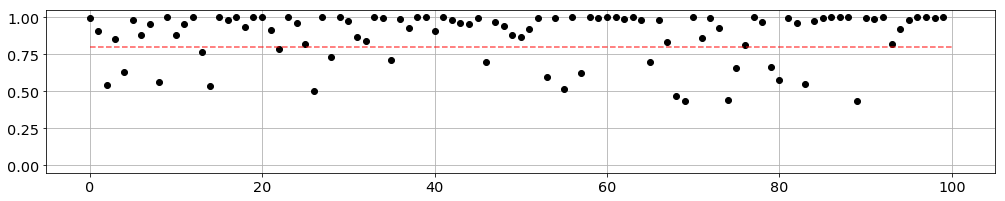

In [58]:
plt.plot(prob[:100],'ko');
plt.plot([0,100],[threshold]*2, 'r--', alpha = .65);
plt.gca().set_ylim([-0.05,1.05])

### 12. Instantiate a Neural Network with same architecture.
### 13. Train on expanded dataset.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_73  (None, 512)               0         
_________________________________________________________________
dense_123 (Dense)            (None, 1000)              513000    
Total params: 513,000
Trainable params: 513,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....
Epoch 00000: val_loss improved from inf to 0.15243, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.15243 to 0.14658, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Runtime: 1 min 59 sec
7680/8000 [===========================>..] - ETA: 0s
At k = 0, 
Test Accuracy = 95.38 %


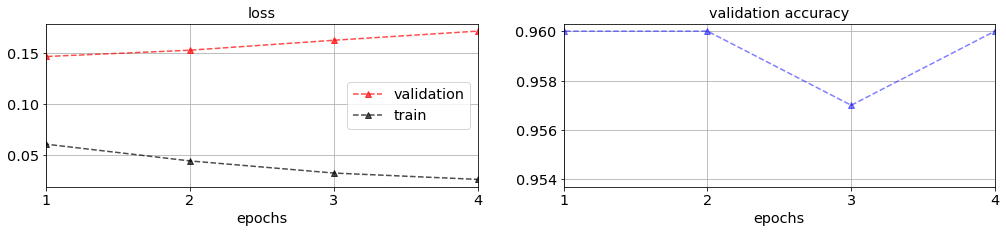

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.16802, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.16802 to 0.16034, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.16034 to 0.15987, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Runtime: 2 min 1 sec
7808/8000 [============================>.] - ETA: 0s
At k = 1, 
Test Accuracy = 95.71 %


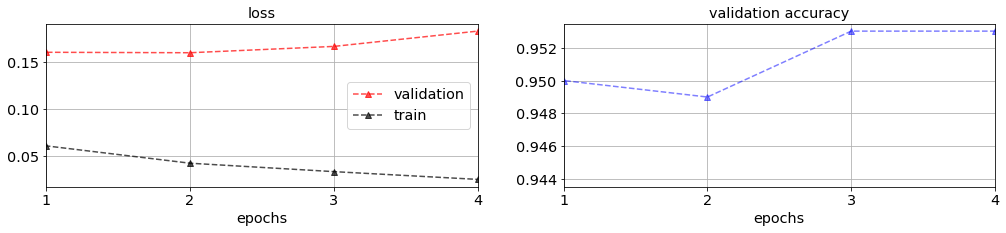

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.19416, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.19416 to 0.18036, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss improved from 0.18036 to 0.17397, saving model to saved_models/model.best.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Runtime: 1 min 59 sec
7808/8000 [============================>.] - ETA: 0s
At k = 2, 
Test Accuracy = 95.65 %


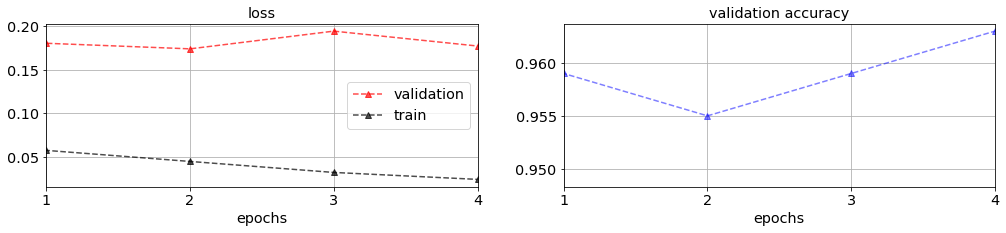

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.19488, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.19488 to 0.19235, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Runtime: 2 min 2 sec
7808/8000 [============================>.] - ETA: 0s
At k = 3, 
Test Accuracy = 95.40 %


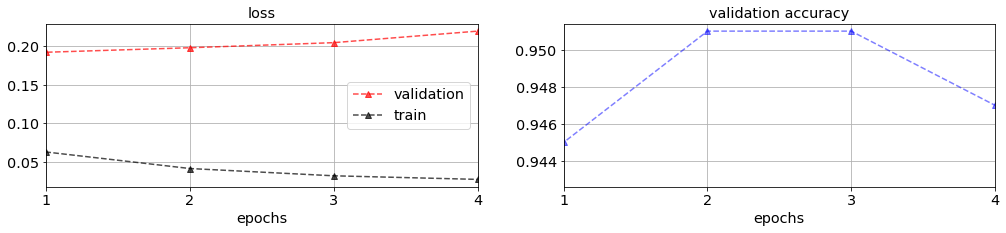

Initiate Training....
Epoch 00000: val_loss improved from inf to 0.12993, saving model to saved_models/model.best.hdf5
Epoch 00001: val_loss improved from 0.12993 to 0.10553, saving model to saved_models/model.best.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Runtime: 2 min 7 sec
7808/8000 [============================>.] - ETA: 0s
At k = 4, 
Test Accuracy = 95.34 %


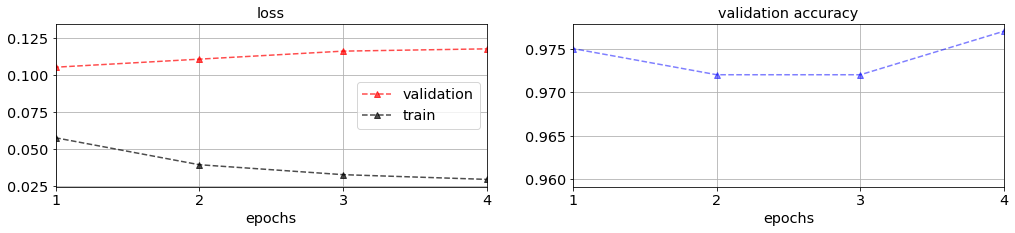



------------------------------
------------------------------
In 5 Folds
K-Fold Average Test Accuracy = 95.49 %  <==
Runtime: 10 min 56 sec


In [60]:
start = time.time()
acc = []

### Do a k-fold
for k, _ in enumerate(fidx):
    fidx_cv = fidx[k]
    fidx_train = np.concatenate([fidx[0:k],fidx[k+1:]]).flatten()
    
    X_cv_features_1k = X_train_features[fidx_cv]
    y_cv_1k = y_train[fidx_cv]
    
    X_train_features_9k = np.concatenate([X_train_features[fidx_train], X_train_add_features])
    y_train_9k = np.concatenate([y_train[fidx_train], y_train_add])
    
    
    ### 5. Construct a Neural Network that accepts VGG16 bottleneck features as input. Call this `model_top`.
    model_top = construct_model()
    if k == 0: model_top.summary()
    ### 6. Train `model_top` on  `X_train_features` with validation on `(X_cv_features, y_cv)`.
    model_top, callback_inst = train_model(model_top, 
                                           X_train_features_9k, y_train_9k,
                                           X_cv_features_1k, y_cv_1k, 
                                           epochs=5,
                                           batch_size=128,
                                           wanna_plot=False)
    ### 7.  Compute test accuracy.
    model_top.load_weights('saved_models/model.best.hdf5')

    _loss, _acc = model_top.evaluate(X_test_features, y_test, 
                                    batch_size=128);
    acc.append(_acc)
    print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

    ### Plot loss function and accuracy
    callback_inst.plotter()

print(('\n' + ('\n'+'-'*30)*2 +'\nIn %i Folds'+ '\nK-Fold Average Test Accuracy = %.2f %%  <==') % 
      (len(fidx), np.mean(acc)*100))
print_runtime(start)

In [62]:
threshold

0.8

#### Training set and the cv set are drawn from the same dataset. Since there's a consistent and substantial difference between the test and validation accuracies (approximately 94% to 98.5%), I'm getting highly skeptical that test and the training datasets might be coming from different distributions. 

In [3]:
!git status
!git add .
!git commit -m "run with threshold=.99,.95,0.90,.80"

On branch master
Your branch is up-to-date with 'origin/master'.
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   main.ipynb

no changes added to commit (use "git add" and/or "git commit -a")
